In [3]:
%run ./Utils.ipynb

In [4]:
# Load dataset function
def load_dataset():
    """Load dataset from files
    Returns
    -------
    train_X : array-like, shape (n_samples_train, n_features)  
              with train samples
    train_Y : array-like, shape (n_samples_train, 1) 
              with train labels
    train_X : array-like, shape (n_samples_test, n_features) 
              with test samples
    train_Y : array-like, shape (n_samples_test, 1) 
              with test labels
    """
    train_X = np.load(f"train_{COLLECTION_FILE_NAME}_x.npy")
    train_Y = np.load(f"train_{COLLECTION_FILE_NAME}_y.npy")
    test_X = np.load(f"test_{COLLECTION_FILE_NAME}_x.npy")
    test_Y = np.load(f"test_{COLLECTION_FILE_NAME}_y.npy")
    return train_X, train_Y, test_X, test_Y

In [5]:
# Load dataset to work with
X_train, Y_train, X_test, Y_test = load_dataset() 
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(320, 10304) (320,) (80, 10304) (80,)


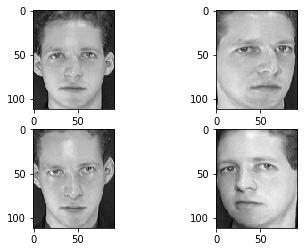

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
ind = 1
for i in X_train[:4]:
    plt.subplot(2, 2,ind)
    plt.imshow(i.reshape((112,92)),cmap='gray')
    ind += 1

In [6]:
# Model realization
from scipy import stats

def chi_square_distance(q, p):
    """Count Chi-Square Distance
    Parameters
    ----------
    q : array-like, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples
        and n_features is the number of features.
    p : array-like, shape (n_features,)
        Sample, where n_features is the number of features
    Returns
    -------
    array-like, shape (n_samples,)
    """
    return np.sum((q-p)**2/p.shape[1]-1,axis=1,keepdims=True)

def euclidean_distance(q, p):
    """Count Euclidean Distance
    Parameters
    ----------
    q : array-like, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples
        and n_features is the number of features.
    p : array-like, shape (n_features,)
        Sample, where n_features is the number of features
    Returns
    -------
    array-like, shape (n_samples,)
    """
    return np.sqrt(np.sum((q - p)**2, axis=1))
    
def model(X_train, y_train, X_test, y_test, use_chi2=False):
    """Build classificator
    Return accuracy of predictions
    Parameters
    ----------
    X_train : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    y_train : array-like, shape (n_samples,)
              Labels, where n_samples is the number of samples
    X_test  : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    y_train : array-like, shape (n_samples,)
              Labels, where n_samples is the number of samples
    Returns
    -------
    preidct : float number, precision of classification
    """
    predict = np.zeros(X_test.shape[0])
    for i in range(X_test.shape[0]):        
        if use_chi2:
            euclid_dist = chi_square_distance(X_test[i], X_train)
        else:
            euclid_dist = euclidean_distance(X_train, X_test[i])
            
        index = np.argsort(euclid_dist, axis=0)[0]
        predict[i] = y_train[index] == y_test[i]
    return predict.mean()

In [7]:
d = model(X_train, Y_train, X_test, Y_test.reshape(-1, 1))
d

0.95

In [8]:
# Shuffle function
def shuffle_samples(x, y):
    """Shuffle data of labels and samples
    Parameters
    ----------
    X : array-like, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples
        and n_features is the number of features.
    y : array-like, shape (n_samples, 1)
        Labels, where n_samples is the number of samples.
    Returns
    -------
    data[:,:-1] : array-like, shape (n_samples, n_features) 
    data[:,-1]  : array-like, shape (n_samples, label)
    """
    data = np.concatenate((x, y.reshape(-1,1)), axis=1)
    np.random.shuffle(data)
    return data[:,:-1] , data[:,-1]

In [9]:
# Extra shuffle for samples
X_train, Y_train = shuffle_samples(X_train, Y_train)
print(X_train.shape, Y_train.shape)

(320, 10304) (320,)


In [10]:
# Default scaling
def minmaxscaler(samples):
    """Scale features by maximum of data
    Parameters
    ----------
    samples : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    Returns
    -------
    samples : array-like, same shape as samples
    """
    return samples/255.

# Scale images A
def scale_by_mean(samples, axis=0):
    """Scale features by mean of data depending on the axis value
    Parameters
    ----------
    samples : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    axis    : number type of int(0, 1)
    Returns
    -------
    samples : array-like, same shape as samples
    """
    return samples - samples.mean(axis=axis,keepdims=True)

# Scale images B
def scale_by_mean_std(samples, axis=0):
    """Scale features by mean diveded by standart deviation
       of data depending on the axis value
    Parameters
    ----------
    samples : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    axis    : number type of int(0, 1)
    Returns
    -------
    samples : array-like, same shape as samples
    """
    return scale_by_mean(samples, axis)/samples.std(axis=axis, keepdims=True)

In [11]:
# Scaling of samples by minmax
X_train_minmax = minmaxscaler(X_train)
X_test_minmax  = minmaxscaler(X_test)

print(X_train_minmax.shape, X_train_minmax.mean())
print(X_test_minmax.shape, X_test_minmax.mean())

d = model(X_train_minmax, Y_train, X_test_minmax, Y_test.reshape(-1, 1))
d

(320, 10304) 0.4415062551854979
(80, 10304) 0.44243154666758017


0.95

In [12]:
# Scale by mean axis=0
X_train_mean = scale_by_mean(X_train, axis=0)
X_test_mean  = scale_by_mean(X_test, axis=0)

print(X_train_mean.shape, X_train_mean.mean())
print(X_test_mean.shape, X_test_mean.mean())

d = model(X_train_mean, Y_train, X_test_mean, Y_test.reshape(-1, 1))
d

(320, 10304) -1.3901923090958483e-16
(80, 10304) -1.1474603186187953e-15


0.9375

In [13]:
# Scale by mean axis=1
X_train_mean_ax = scale_by_mean(X_train, axis=1)
X_test_mean_ax  = scale_by_mean(X_test, axis=1)

print(X_train_mean_ax.shape, X_train_mean_ax.mean())
print(X_test_mean_ax.shape, X_test_mean_ax.mean())

d = model(X_train_mean_ax, Y_train, X_test_mean_ax, Y_test.reshape(-1, 1))
d

(320, 10304) -5.770401409977211e-16
(80, 10304) -5.295970701317517e-17


0.9375

In [14]:
# Scale by mean std axis=0
X_train_mean_std = scale_by_mean_std(X_train, axis=0)
X_test_mean_std  = scale_by_mean_std(X_test, axis=0)

print(X_train_mean_std.shape, X_train_mean_std.mean())
print(X_test_mean_std.shape, X_test_mean_std.mean())

d = model(X_train_mean_std, Y_train, X_test_mean_std, Y_test.reshape(-1, 1))
d

(320, 10304) 3.516855543843664e-18
(80, 10304) -1.351575856065408e-17


0.9375

In [15]:
# Scale by mean std axis=1
X_train_mean_std_ax = scale_by_mean_std(X_train, axis=1)
X_test_mean_std_ax  = scale_by_mean_std(X_test, axis=1)

print(X_train_mean_std_ax.shape, X_train_mean_std_ax.mean())
print(X_test_mean_std_ax.shape, X_test_mean_std_ax.mean())

d = model(X_train_mean_std_ax, Y_train, X_test_mean_std_ax, Y_test.reshape(-1, 1))
d

(320, 10304) -4.47364712562466e-18
(80, 10304) 1.2964094945933505e-17


0.9375

In [16]:
# PCA realization
def get_data(A):
    """Count centered matrix C
    Parameters
    ----------
    A : array-like, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples
        and n_features is the number of features.
    Returns
    -------
    C : array-like, same shape as samples
    """
    # calculate the mean of each column
    M = np.mean(A, axis=0)
    # center columns by subtracting column means
    C =  A - M
    return C

def get_svd(C):
    """Count singular value decomposition of matrix C
    Method count explained variance and explained variance ratio
    Parameters
    ----------
    C : array-like, shape (n_samples, n_features)
        Samples, where n_samples is the number of samples
        and n_features is the number of features.
    Returns
    -------
    values  : array-like, shape (n_features,) diagonal matrix of singular values
    vectors : array-like, shape (n_features, n_features)
    explained_variance       : shape (n_features,) where n_features is 
                               a number of components
    explained_variance_ratio : shape (n_features,) where n_features is 
                               a number of components
    """
    # svd method
    vectors, values, V = np.linalg.svd(C.T)
    
    # count diagonal matrix of eigenvector
    explained_variance = (values ** 2) / (C.shape[0] - 1)
    
    # count explained variance ratio     
    total_var = explained_variance.sum()
    explained_variance_ratio = explained_variance / total_var
    
    return values, vectors, explained_variance, explained_variance_ratio, V

def explained_variance(values, ratio):
    """Count decision how many n components will be used
    Parameters
    ----------
    values : array-like, shape (n_components,)
             Explained variance ratio where n_components
             is the number of components.
    ratio  : float number, number in range (0, 1)
    Returns
    -------
    container : array-like, shape(n_components_reduced,)
                where n_components_reduced < n_components
    """
    container = []
    accumulator = 0. 

    for i in values:
        if accumulator <= ratio:
            accumulator += i
            container.append(i)
    
    return np.asarray(container)

def reduce_dimensions(matrix_W, n_comp, C):
    """Apply dimension reduction for matrix C
    Parameters
    ----------
    matrix_W : array-like, shape (n_features, n_features)
               Matrix W, where n_features is the number of features.
    n_comp   : array-like, shape (n_components_reduced,) 
               Selected principal components, where n_components_reduced
               is a number of components to use.
    С        : array-like, shape (n_samples, n_features)
               Samples, where n_samples is the number of samples
               and n_features is the number of features.
    Returns
    -------
    C : array-like, shape(n_samples, n_components_reduced)
    """
    return C.dot(matrix_W.T[:n_comp.shape[0]].T)

In [17]:
# Fit X_train
train_matrix_C = get_data(X_train_mean_std)
eigen_values, eigen_vectors,exp_var, exp_ratio, V_matrix = get_svd(train_matrix_C)

exp_ratio_n_comp = explained_variance(exp_ratio, .99)

# Transform X_train
X_train_PCA_mean = reduce_dimensions(eigen_vectors, exp_ratio_n_comp, train_matrix_C)
print(X_train_PCA_mean.shape)

# Transform X_test
test_matrix_C = get_data(X_test_mean_std)

X_test_PCA_mean = reduce_dimensions(eigen_vectors, exp_ratio_n_comp, test_matrix_C)
print(X_test_PCA_mean.shape)

(320, 266)
(80, 266)


In [18]:
# PCA on scaled by mean std axis=0
d = model(X_train_PCA_mean, Y_train, X_test_PCA_mean, Y_test.reshape(-1, 1))
d

0.9375

In [19]:
# Fit X_train
train_matrix_C = get_data(X_train_minmax)
eigen_values, eigen_vectors,exp_var, exp_ratio, V_matrix = get_svd(train_matrix_C)

exp_ratio_n_comp = explained_variance(exp_ratio, .99)
# Transform X_train
X_train_PCA_minmax = reduce_dimensions(eigen_vectors, exp_ratio_n_comp, train_matrix_C)
print(X_train_PCA_minmax.shape)

# Transform X_test
test_matrix_C = get_data(X_test_minmax)

X_test_PCA_minmax = reduce_dimensions(eigen_vectors, exp_ratio_n_comp, test_matrix_C)
print(X_test_PCA_minmax.shape)

(320, 265)
(80, 265)


In [20]:
# PCA on default
d = model(X_train_PCA_minmax, Y_train, X_test_PCA_minmax, Y_test.reshape(-1, 1))
d

0.9375

In [16]:
from skimage import feature

def image_split(image, N):
     """Split image into N parts
    Parameters
    ----------
    image : array-like, shape (height, width) Image
    Returns
    -------
    contrainer : array-like, shape of (N, block_height, block_width)
    """
    block_width  = image.shape[1] // N
    block_height = image.shape[0] // N 

    block_coordinate_x = 0
    block_coordinate_y = 0
    
    container = []
    
    for y in range(N):
        block_coordinate_y = block_height * y
        for x in range(N):
            block_coordinate_x = block_width * x
            block = image[block_coordinate_y:block_coordinate_y + block_height, 
                          block_coordinate_x:block_coordinate_x + block_width]
            container.append(block)
    return np.asarray(container)

def describe(image, radius, points=57):
    """Transform given image to LBP histogram
    Parameters
    ----------
    image  : array-like, shape (height, width) Image
    radius : int number, radius of circle
    points : int number, number of neighbour points
    Returns
    -------
    hist   : array-like, histogram of LBP image
    """
    r_point = radius*8
    num_points = (r_point*(r_point-1)+2)+1

    lbp = feature.local_binary_pattern(image, num_points,
            radius, method="uniform")
    #     imshow(lbp, cmap='gray')

    (hist, _) = np.histogram(lbp.ravel(),
            bins=np.arange(0, num_points))

    # return the histogram of Local Binary Patterns
    return hist

def apply_LBP(samples, radius, points=57, N=False):
    """Transform given image to LBP histogram
    Parameters
    ----------
    samples : array-like, shape (n_samples, n_features)
              Samples, where n_samples is the number of samples
              and n_features is the number of features.
    radius  : int number, radius of circle
    points  : int number, number of neighbour points
    N       : boolean flag, quantity of blocks for image separation
              (N=2 4 blocks)
    Returns
    -------
    LBP_samples : array-like, histogram of LBP image
    """
    LBP_samples = []

    if (N == 1):   
        for sample in samples.reshape(-1, 112,92): 
            LBP_samples.append(describe(sample, radius, points))
    else:
        for sample in samples.reshape(-1, 112,92):
            LBP_image = []
            
            for part in image_split(sample, N):
                lbp_part = describe(part, radius, points)
                LBP_image.append(lbp_part)
            
            LBP_samples.append(np.asarray(LBP_image).flatten())
    return np.asarray(LBP_samples)

array([ 519,   92,   87,   93,   96,   85,   93,   74,   75,   67,   51,
         55,   62,   48,   55,   63,   65,   73,   84,   92,  124,   98,
        143,  147,  188,  222,  322,  319,  369,  362,  271,  229,  179,
        144,  116,  110,   85,   75,   57,   67,   50,   54,   56,   49,
         44,   49,   38,   38,   54,   46,   76,   76,   78,  106,   87,
         89,   62,  455, 3241])

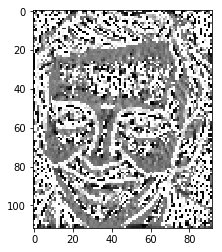

In [54]:
describe(X_train[170].reshape(112,92), 2)

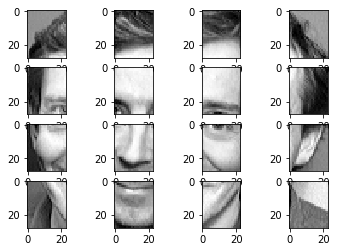

In [51]:
splitted = image_split(X_train[170].reshape(112,92), 4)
ind = 1
for i in splitted:
    plt.subplot(4, 4,ind)
    plt.imshow(i.reshape((28, 23)),cmap='gray')
    ind += 1

In [17]:
# Apply LBP to dataset
radius = 1
N = 6

X_train_LBP = apply_LBP(X_train, radius, N=N)
X_test_LBP  = apply_LBP(X_test, radius, N=N)

print(X_train_LBP.shape, X_test_LBP.shape)

(320, 2088) (80, 2088)


In [18]:
# Accuracy on samples with LBP
d = model(X_train_LBP, Y_train, X_test_LBP, Y_test.reshape(-1, 1),use_chi2=True)
d

0.9625